In [204]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [241]:
class simplefunctions:
    def __init__(self, K, actionspace, dim):
        self.K=K
        self.dim=dim
        self.actionspace = actionspace #self.generate_clusters()
        self.subset = self.algorithm()

    # def generate_clusters(self, n_clusters=4, points_per_cluster=50, spread=0.1, seed=None):
    #     if seed is not None:
    #         np.random.seed(seed)
    #     centers = np.random.uniform(-1, 1, size=(n_clusters, 2))  # cluster centers
    #     points = []
    #     for center in centers:
    #         cluster_points = np.random.randn(points_per_cluster, 2) * spread + center
    #         points.append(cluster_points)
    #     return np.vstack(points)[:,:] #, centers

    def generate_bandits(self, num_samples):
        """
        Generate dim-dimensional zero-mean Gaussian samples with a PSD covariance matrix.
        """
        mean_col = np.zeros(self.dim)
        covariance_matrix = np.eye(self.dim)
        samples = np.random.multivariate_normal(mean=mean_col, cov=covariance_matrix, size=num_samples)
        return samples #, covariance_matrix

    def algorithm(self):
        subset=[]
        # while len(subset)< self.K: # add more items until K distinct actions are found
        theta_set = self.generate_bandits(self.K)
        for theta in theta_set:
            selected=np.argmax(np.dot(self.actionspace,theta.reshape((self.dim,1))))
            subset = np.append(subset,int(selected))
        subset = np.unique(subset)    
        return [int(i) for i in subset]
    
    def test(self):
        num_batches = 10**4  # Number of function samples for testing
        regret=[]
        theta_set = self.generate_bandits(num_batches)
        for theta in theta_set:
            regret.append(np.max(np.dot(self.actionspace,theta.reshape((self.dim,1))))
                        -np.max(np.dot(self.actionspace[self.subset,:],theta.reshape((self.dim,1)))))
        # print(np.average(regret))
        return np.average(regret)

In [149]:
def generate_clustered_points(n_points=100, n_clusters=3, radius=1.0, scale=0.1):
    points = []
    points_per_cluster = n_points // n_clusters

    # Step 1: Generate random cluster centers inside the unit ball
    for _ in range(n_clusters):
        while True:
            center = np.random.uniform(-1, 1, size=2)
            if np.linalg.norm(center) <= radius - 0.2:  # keep some margin for spread
                break

        # Step 2: Generate points around the center, constrained to the unit ball
        for _ in range(points_per_cluster):
            while True:
                offset = np.random.normal(scale=scale, size=2)
                point = center + offset
                if np.linalg.norm(point) <= radius:
                    points.append(point)
                    break

    # In case n_points is not divisible by n_clusters
    while len(points) < n_points:
        points.append(points[np.random.randint(len(points))])
    return np.array(points)

In [374]:
def random_unit_vector():
    vec = np.random.normal(size=3)
    return vec / np.linalg.norm(vec)

def generate_cluster(center, num_points, spread):
    points = []
    for _ in range(num_points):
        noise = np.random.normal(scale=spread, size=3)
        point = center + noise
        point /= np.linalg.norm(point)  # Project back onto the unit sphere
        points.append(point)
    return np.array(points)

def generate_clusters_on_sphere(n_points=100, num_clusters=3, spread=0.1, center_points=None):
    all_points = []
    labels = []
    points_per_cluster = n_points // num_clusters
    for cluster_id in range(num_clusters):
        if len(center_points)>0:
            center = center_points[cluster_id]
        else:
            center = random_unit_vector()
        cluster_points = generate_cluster(center, points_per_cluster, spread)
        all_points.append(cluster_points)
        labels.extend([cluster_id] * points_per_cluster)
    return np.vstack(all_points) #, np.array(labels)

In [422]:
# Fixed center points
num_clusters=5
np.random.seed(21)
c = []
for cluster_id in range(num_clusters):
    c.append(random_unit_vector())
center_points=np.vstack(c)

In [423]:
# Generate clusters
np.random.seed(21)
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.5, center_points=center_points)

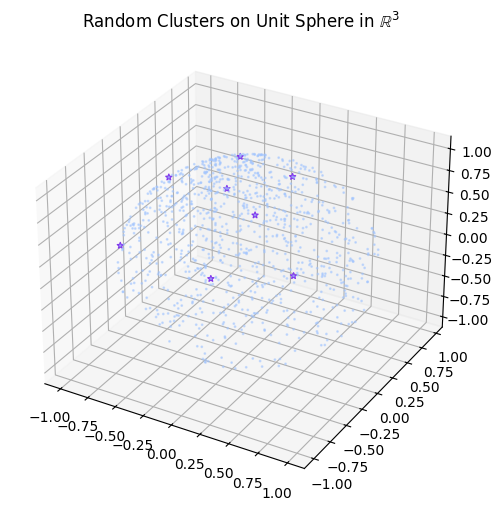

In [378]:
# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:,0], points[:,1], points[:,2],s=1,alpha=0.5,color= "#A0C4FF" )

fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset
ax.scatter(points[subset_idx,0], points[subset_idx,1], points[subset_idx,2],marker='*',s=20,alpha=1,color='#8338ec')

ax.set_title("Random Clusters on Unit Sphere in $\mathbb{R}^3$")
plt.show()

In [379]:
K = 10
s_values = np.linspace(0.01,0.5,10)  # Example values for R
results = {}

np.random.seed(21)
for s in s_values:
    outputs = []
    for _ in range(30):  # Run multiple trials for statistical robustness
        pts = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=s, center_points=center_points)
        fun = simplefunctions(K=K,dim=3,actionspace=pts)
        output = fun.test()
        outputs.append(output)
    outputs = np.array(outputs)
    results[s] = {
        'mean': np.mean(outputs),
        'std': np.std(outputs)
    }

# Print results
for s in results:
    print(f"s = {s}: mean = {results[s]['mean']:.4f}, std = {results[s]['std']:.4f}")

s = 0.01: mean = 0.0304, std = 0.0431
s = 0.06444444444444444: mean = 0.0974, std = 0.0615
s = 0.11888888888888888: mean = 0.1509, std = 0.0530
s = 0.17333333333333334: mean = 0.1939, std = 0.0645
s = 0.22777777777777777: mean = 0.2192, std = 0.0668
s = 0.2822222222222222: mean = 0.2575, std = 0.0719
s = 0.33666666666666667: mean = 0.2703, std = 0.0471
s = 0.3911111111111111: mean = 0.2766, std = 0.0660
s = 0.44555555555555554: mean = 0.2790, std = 0.0580
s = 0.5: mean = 0.2846, std = 0.0699


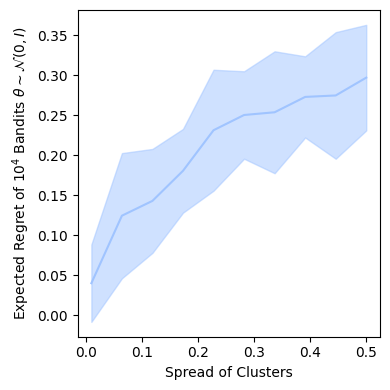

In [313]:
plt.figure(figsize=(4,4))

mean_values = np.array([results[s]['mean'] for s in s_values])
std_values = np.array([results[s]['std'] for s in s_values])

plt.plot(s_values, mean_values, label=f'epsilon = {s}',color="#A0C4FF")  # Mean curve
plt.fill_between(s_values, mean_values - std_values, mean_values + std_values,color="#A0C4FF",alpha=0.5)

# Labeling the plot
# plt.title('Results with Error Shade')
plt.xlabel(r'Spread of Clusters')
plt.ylabel(r'Expected Regret of $10^4$ Bandits $\theta\sim\mathcal{N}(0,I)$')
plt.tight_layout()

# Show the plot
plt.show()

In [416]:
center_points

array([[-0.04953684, -0.10600174,  0.99313128],
       [-0.55853969,  0.33127682, -0.76045321],
       [-0.17587457, -0.20039953,  0.96379882],
       [-0.00839273, -0.40760683,  0.91311896],
       [ 0.85513547, -0.36585132,  0.3672821 ]])

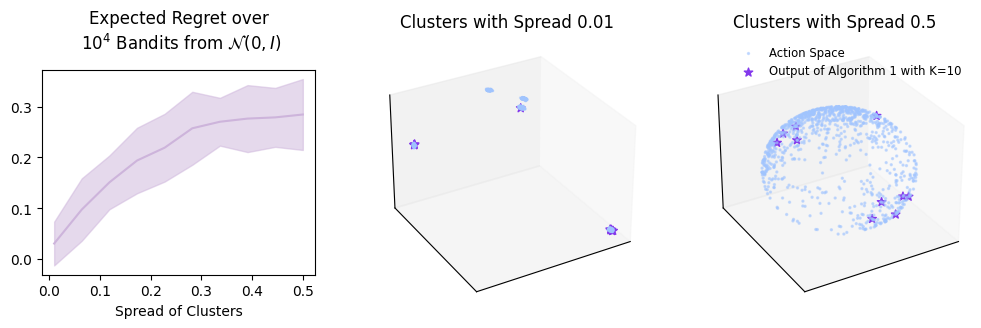

In [434]:
# Start 3 plots in a row
fig = plt.figure(figsize=(12, 6))

# Plot 1 (3D)
# Example generation (replace this with your own)
np.random.seed(21)
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.01, center_points=center_points)
fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.scatter(points[:,0], points[:,1], points[:,2],s=1,alpha=0.5,color= "#A0C4FF")
ax1.scatter(points[subset_idx,0], points[subset_idx,1], points[subset_idx,2],marker='*',s=40,alpha=1,color='#8338ec')
ax1.set_title("Clusters with Spread 0.01")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([]); ax1.grid(False)
ax1.view_init(elev=30, azim=60)  # Different view

# Plot 2 (3D)
np.random.seed(21)
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.5, center_points=center_points)
fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.scatter(points[:, 0], points[:, 1], points[:, 2], s=2, alpha=0.5, color="#A0C4FF",label='Action Space')
ax2.scatter(points[subset_idx, 0], points[subset_idx, 1], points[subset_idx, 2],marker='*', s=40, alpha=1, color='#8338ec',label='Output of Algorithm 1 with K=10')
ax2.set_title("Clusters with Spread 0.5")
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([]); ax2.grid(False)
ax2.legend(loc='upper right', fontsize='small', frameon=False)
ax2.view_init(elev=30, azim=60)  # Different view

# Plot 3 (Different: 2D projection or histogram, example: x-y plane projection)
ax3 = fig.add_subplot(1, 3, 1)
mean_values = np.array([results[s]['mean'] for s in s_values])
std_values = np.array([results[s]['std'] for s in s_values])

ax3.plot(s_values, mean_values, label=f'epsilon = {s}',color="#cdb4db")  # Mean curve
ax3.fill_between(s_values, mean_values - std_values, mean_values + std_values,color="#cdb4db",alpha=0.5)
# ax3.set_xticks([]); ax3.set_yticks([])
ax3.set_xlabel(r'Spread of Clusters')
ax3.set_title('Expected Regret over\n $10^4$ Bandits from $\mathcal{N}(0,I)$',pad=15)
# ax3.set_title("2D Projection (x-y)")
ax3.set_aspect('equal')
# ax3.axis('off')

plt.savefig("Clusters.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)
# plt.tight_layout()
plt.show()

In [ ]:
# Generate clusters
fig, axes = plt.subplots(1,3,figsize=(12, 5))  # (rows, cols)
np.random.seed(21)


points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.5)
# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:,0], points[:,1], points[:,2],s=1,alpha=0.5,color= "#A0C4FF" )

fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset
ax.scatter(points[subset_idx,0], points[subset_idx,1], points[subset_idx,2],marker='*',s=20,alpha=1,color='#8338ec')

ax.set_title("Random Clusters on Unit Sphere in $\mathbb{R}^3$")
plt.show()

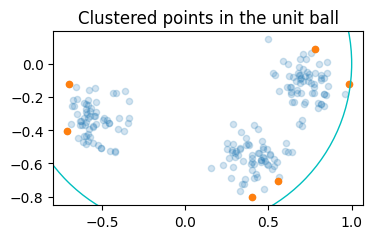

In [203]:
plt.figure(figsize=(4,4))
np.random.seed(4)
pts = generate_clustered_points(n_points=200, n_clusters=3, scale=0.1)
fun=simplefunctions(K,pts)
subset_idx=fun.subset
plt.scatter(pts[:, 0], pts[:, 1],s=20,alpha=0.2)
plt.scatter(pts[subset_idx, 0], pts[subset_idx, 1],s=20,alpha=1)
circle = plt.Circle((0, 0), 1, color='c', fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal')
plt.title("Clustered points in the unit ball")
plt.show()

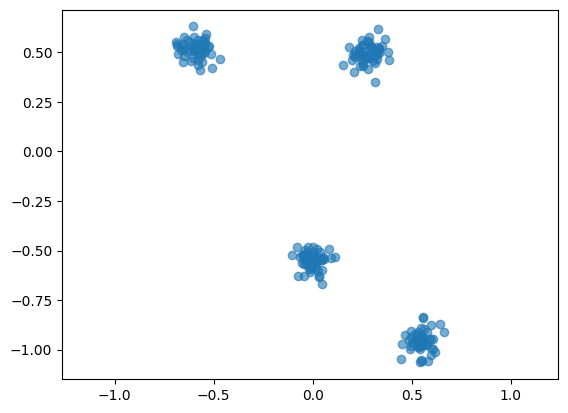

In [22]:
plt.scatter(points[:, 0], points[:, 1], alpha=0.6)
# plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x')  # cluster centers
plt.axis('equal')
plt.show()

In [337]:
def thompson_sampling_action_selection(alpha, beta, K=5):
    """
    Selects a subset of K actions using Thompson Sampling.
    
    alpha, beta: Parameters of the Beta distribution for each action.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    sampled_values = np.random.beta(alpha, beta)  # Sample from Beta distribution
    selected_actions = np.argsort(sampled_values)[-K:]  # Select top K actions
    return selected_actions

# Example usage
num_actions = 10
alpha = np.ones(num_actions)  # Prior successes (initialize as 1)
beta = np.ones(num_actions)   # Prior failures (initialize as 1)
selected_actions = thompson_sampling_action_selection(alpha, beta, K=5)

print("Selected actions using Thompson Sampling:", selected_actions)

Selected actions using Thompson Sampling: [2 5 6 0 7]


In [338]:
def ucb_action_selection(Q, N, t, c=1.0, K=5):
    """
    Selects a subset of K actions using Upper Confidence Bound (UCB).
    
    Q: Estimated rewards for each action.
    N: Number of times each action has been selected.
    t: Current time step.
    c: Exploration-exploitation trade-off parameter.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    ucb_values = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
    selected_actions = np.argsort(ucb_values)[-K:]  # Top K actions with highest UCB
    return selected_actions

# Example usage
num_actions = 10
Q = np.random.rand(num_actions)  # Random estimated rewards
N = np.ones(num_actions)  # Initialize with 1 to avoid division by zero
t = 100  # Current time step
selected_actions = ucb_action_selection(Q, N, t, K=5)

print("Selected actions using UCB:", selected_actions)


Selected actions using UCB: [2 8 9 0 1]


In [194]:


dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
mean=np.array([dfmean[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])
dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
std=np.array([dfstd[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])



In [277]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.968969
             10.0          0.658666
0.2          5.0           0.969845
             10.0          0.612436
0.5          5.0           0.664523
             10.0          0.370710
1.0          5.0           0.515914
             10.0          0.279531
1.5          5.0           0.404753
             10.0          0.112570
2.0          5.0           0.258277
             10.0          0.106087